<a href="https://colab.research.google.com/github/asylunatic/ASDFPixelSort/blob/master/Reproducability_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set TF version & imports

In [0]:
%tensorflow_version 1.x

!pip install -q kaggle

from pathlib import Path
from PIL import Image, ImageSequence
import keras.layers
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math as math
import os as os
from google.colab import files


# Download dataset

In [0]:
def download_data(tiny_normal, tiny_rotated, large_normal):
  os.environ['KAGGLE_USERNAME'] = "sranjha" # username from the json file
  os.environ['KAGGLE_KEY'] = "57d3733a9bceac9771f0295b9f791080" # key from the json file

  if tiny_normal and not Path('/content/rotated-tiny-augmented-segmentation-challenge-data.zip').exists():
    !kaggle datasets download sranjha/rotated-tiny-augmented-segmentation-challenge-data
    !unzip -q /content/rotated-tiny-augmented-segmentation-challenge-data.zip -d rotated-tiny-augmented-segmentation-challenge-data
  
  if tiny_rotated and not Path('/content/split-tiny-augmented-segmentation-challenge-data.zip').exists():
    !kaggle datasets download sranjha/split-tiny-augmented-segmentation-challenge-data
    !unzip -q /content/split-tiny-augmented-segmentation-challenge-data.zip -d split-tiny-augmented-segmentation-challenge-data
  
  if large_normal and not Path('/content/50x-augmented-segmentation-challenge-data.zip').exists():
    !kaggle datasets download sranjha/50x-augmented-segmentation-challenge-data
    !unzip -q /content/50x-augmented-segmentation-challenge-data.zip -d 50x-augmented-segmentation-challenge-data

In [0]:
download_data(tiny_normal = False, tiny_rotated = True, large_normal = False)

 85% 57.0M/67.0M [00:00<00:00, 69.8MB/s]
100% 67.0M/67.0M [00:00<00:00, 98.3MB/s]


# Prepare dataset

In [0]:
def load_data(path):
  listylist = []
  for filename in sorted(os.listdir(path)):
    img = Image.open(path+'/'+filename)
    dtype = {'F': np.float32, 'L': np.uint8}[img.mode]
    listylist.append(np.array(img.getdata(), dtype=dtype)/255.0)

  listylist = np.array(listylist)
  return listylist

def load_and_crop_data(path):
  listylist = []
  for filename in sorted(os.listdir(path)):
    img = Image.open(path+'/'+filename)
    dtype = {'F': np.float32, 'L': np.uint8}[img.mode]
    width, height = img.size  # Get dimensions
    left = (width - 512) / 2
    top = (height - 512) / 2
    right = (width + 512) / 2
    bottom = (height + 512) / 2
    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    label_temp = np.array(img.getdata(), dtype=dtype)/255.0
    label_temp_inv = abs(label_temp-1.0)
    listylist.append([label_temp, label_temp_inv])

  listylist = np.array(listylist)
  listylist = np.swapaxes(listylist, 1, 2)
  return listylist

dataset = 'rotated-tiny-augmented-segmentation-challenge-data'
#dataset = 'split-tiny-augmented-segmentation-challenge-data'
#dataset = '50x-augmented-segmentation-challenge-data'
train_path = '/content/'+dataset+'/train_5x'
train_labels_path = '/content/'+dataset+'/train_labels_5x'
test_path = '/content/'+dataset+'/test_5x'
test_labels_path = '/content/'+dataset+'/test_labels_5x'

x_train = load_data(train_path)
x_train_labels = load_and_crop_data(train_labels_path)
x_test = load_data(test_path)
x_test_labels = load_and_crop_data(test_labels_path)

x_train = np.reshape(x_train, (len(x_train), 700, 700, 1))
x_test = np.reshape(x_test, (len(x_test), 700, 700, 1))
x_test_labels = np.reshape(x_test_labels, (len(x_test_labels), 512, 512, 2))
x_train_labels = np.reshape(x_train_labels, (len(x_train_labels), 512, 512, 2))

x_test shape = (30, 490000)
x_train shape = (270, 490000)
x_train_labels = (270, 262144, 2)
x_test_labels shape = (30, 262144, 2)


# Set up & compile architecture:

In [0]:
np.random.seed(666) # for reproducibility

unet = Sequential()

# A little explaination of the variables naming below: the naming is an indication
# of the dimensions I expected for the layer to have, in order to debug more easily.
# The variable naming is as follows: e or d for encoding or decoding layer, then the expected
# x and y dimensions of each channel and lastly the number of channels. The expected sizes
# are based on an input image of 700*700*1.
input_img = Input(shape=(700, 700, 1))
e570_64 = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_img) 
e568_64 = Conv2D(64, (3, 3), activation='relu', padding='valid')(e570_64) 
e284_64 = MaxPooling2D((2,2))(e568_64) 

e282_128= Conv2D(128, (3, 3), activation='relu', padding='valid')(e284_64)
e280_128= Conv2D(128, (3, 3), activation='relu', padding='valid')(e282_128)
e140_128 = MaxPooling2D((2,2))(e280_128) 

e138_256 = Conv2D(256, (3, 3), activation='relu', padding='valid')(e140_128)
e136_256 = Conv2D(256, (3, 3), activation='relu', padding='valid')(e138_256)
e68_256 = MaxPooling2D((2,2))(e136_256)

e66_512 = Conv2D(512, (3, 3), activation='relu', padding='valid')(e68_256)
e64_512 = Conv2D(512, (3, 3), activation='relu', padding='valid')(e66_512)
e32_512 = MaxPooling2D((2,2))(e64_512) 

e30_1024 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(e32_512) 
e28_1024 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(e30_1024) 

# NOW WE START UPCONVOLVING :D
d56_1024 = UpSampling2D()(e28_1024)
d56_512 = Conv2D(512, (2, 2), padding='same')(d56_1024)
add_56 = Cropping2D(cropping=((4, 4), (4, 4)), data_format=None)(e64_512) # crop 64*64*512 to 56*56*512
d56_1024 = concatenate([add_56, d56_512]) # add layers together to a 56*56*1024 chunk
d54_512 = Conv2D(512, (3, 3), activation='relu', padding='valid')(d56_1024)
d52_512 = Conv2D(512, (3, 3), activation='relu', padding='valid')(d54_512)

d104_256 = UpSampling2D()(d52_512) # upconvolve to 104*104*256
d104_256 = Conv2D(256, (2, 2), padding='same')(d104_256)
add_104 = Cropping2D(cropping=((16, 16), (16, 16)), data_format=None)(e136_256) # crop 136*136*256 to 104*104*256
d104_512 = concatenate([add_104, d104_256]) # add layers together to an 104*104*512 chunk
d102_256 = Conv2D(256, (3, 3), activation='relu', padding='valid')(d104_512) 
d100_256 = Conv2D(256, (3, 3), activation='relu', padding='valid')(d102_256) 

d200_128 = UpSampling2D()(d100_256) # upconvolve to 200*200*128
d200_128 = Conv2D(128, (2, 2), padding='same')(d200_128)
add_200 = Cropping2D(cropping=((40, 40), (40, 40)), data_format=None)(e280_128) # crop 280*280*128 to 200*200*128 chunk
d200_256 = concatenate([add_200, d200_128]) # add together to 200*200*256 chunk
d198_128 = Conv2D(128, (3, 3), activation='relu', padding='valid')(d200_128) 
d196_128 = Conv2D(128, (3, 3), activation='relu', padding='valid')(d198_128)

d392_64 =  UpSampling2D()(d196_128) # upconvolve to 392*392*64
d392_64 = Conv2D(64, (2, 2), padding='same')(d392_64)
add_392 = Cropping2D(cropping=((88, 88), (88, 88)), data_format=None)(e568_64) # crop 568*568*64 to 392*392*64
d392_128 = concatenate([add_392, d392_64]) # add together to 392*392*128 chunk
d390_64 = Conv2D(64, (3, 3), activation='relu', padding='valid')(d392_128)
d388_64 = Conv2D(64, (3, 3), activation='relu', padding='valid')(d390_64)
output = Conv2D(2, (1, 1), activation='softmax', padding='valid')(d388_64)
output = Cropping2D(cropping=((2,2), (2,2)), data_format=None)(output)

unet = Model(input_img, output)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.99, nesterov=False)

unet.compile(optimizer=sgd, loss='binary_crossentropy')

#Now Train!

In [0]:
num_epochs = 100

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001)

history = unet.fit(x_train, x_train_labels, validation_split=0.2, 
                epochs = num_epochs,
                callbacks=[reduce_lr],
                batch_size=5)

Train on 216 samples, validate on 54 samples
Epoch 1/100
216/216 [==============================] - 47s 219ms/step - loss: 0.5452 - val_loss: 0.5097
Epoch 2/100
216/216 [==============================] - 46s 213ms/step - loss: 0.4533 - val_loss: 0.5584
Epoch 3/100
216/216 [==============================] - 46s 213ms/step - loss: 0.4357 - val_loss: 0.3990
Epoch 4/100
216/216 [==============================] - 46s 213ms/step - loss: 0.3940 - val_loss: 0.3599
Epoch 5/100
216/216 [==============================] - 46s 213ms/step - loss: 0.3728 - val_loss: 0.3610
Epoch 6/100
216/216 [==============================] - 46s 213ms/step - loss: 0.3604 - val_loss: 0.3623
Epoch 7/100
216/216 [==============================] - 46s 213ms/step - loss: 0.3710 - val_loss: 0.3511
Epoch 8/100
216/216 [==============================] - 46s 213ms/step - loss: 0.3694 - val_loss: 0.3407
Epoch 9/100
216/216 [==============================] - 46s 213ms/step - loss: 0.3418 - val_loss: 0.3293
Epoch 10/100
216/21

# Save weights

In [0]:
unet.save_weights("trained_opt_sgd_"+str(num_epochs)+"eps_wlrscheduling.h5")

# Plot learning Curve

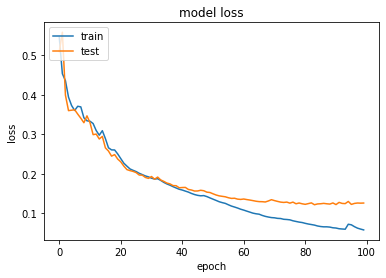

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('learning_curve_opt_sgd_'+str(num_epochs)+'eps_wvalidation.png')
# files.download('learning_curve_opt_sgd_'+str(num_epochs)+'eps_wvalidation.png') # uncomment to save image to disk
plt.show()


# Predict

In [0]:
segmented_imgs = unet.predict(x_test[0:10])

# Plot results

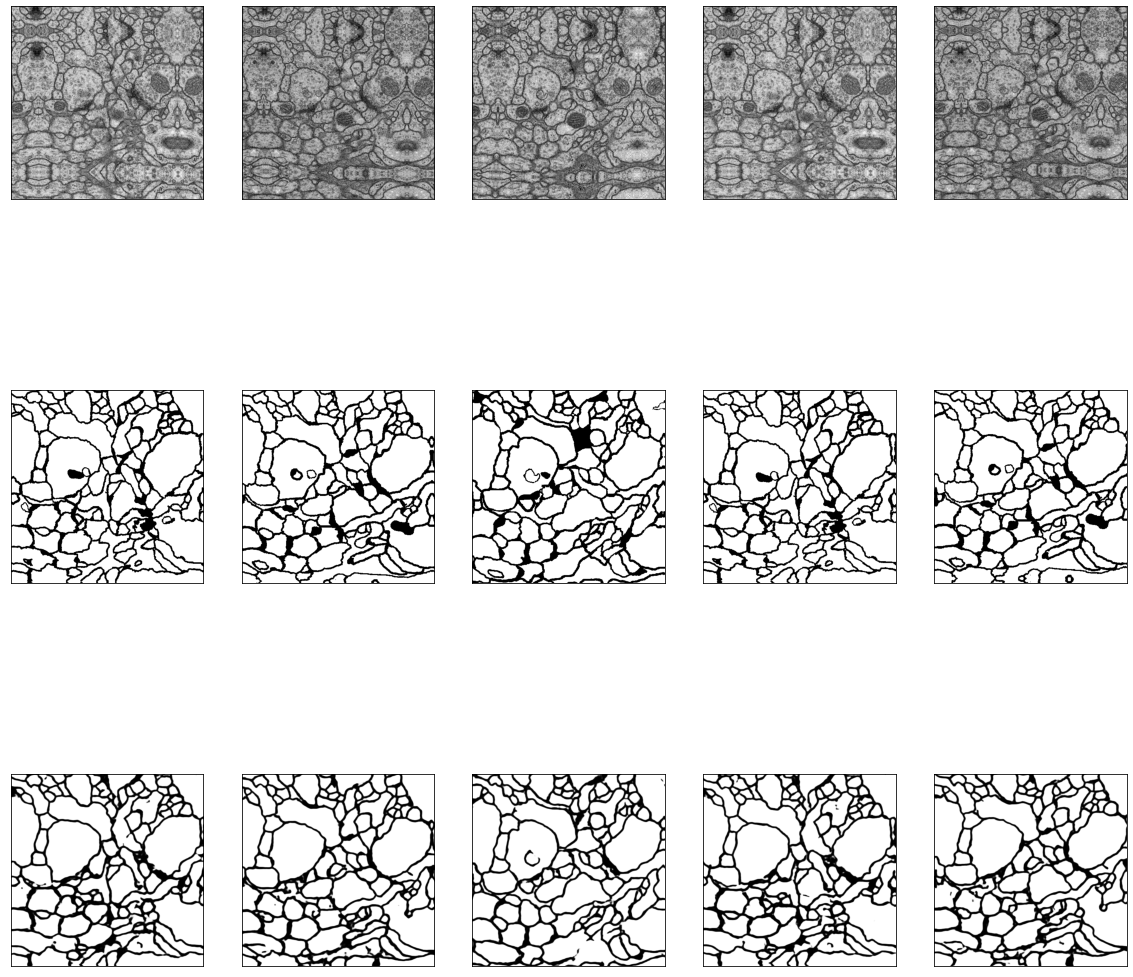

In [0]:
n = 5
plt.figure(figsize=(20,20))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    pic = x_test[i].reshape(700, 700, 1)
    plt.imshow(pic[:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    pic = x_test_labels[i].reshape(512, 512, 2)
    plt.imshow(pic[:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n  + n + 1)
    pic = segmented_imgs[i].reshape(512, 512, 2)
    plt.imshow(pic[:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('plotresults_sgd_'+str(num_epochs)+'eps.png')
# files.download('plotresults_sgd_'+str(num_epochs)+'eps.png') # uncomment to save file to disk
plt.show()

# Evaluate results quantitatively


In [0]:
def pixelerror_k(output: np.ndarray, label: np.ndarray):
  return np.sum(output != label)/output.size

def mask_k(output: np.ndarray):
  masked = output
  masked[masked < 0.5] = 0
  masked[masked >= 0.5] = 1
  return masked.astype('int')

def iou_k(predicted: np.ndarray, label: np.ndarray):
  intersection = (predicted & label.astype('int')).sum((0,1,2))
  union = (predicted | label.astype('int')).sum((0,1,2))
  return intersection / union

masked = mask_k(segmented_imgs[:,:,:,0])
IOU = iou_k(masked, x_test_labels[0:10,:,:,0])

print(pixelerror_k(masked, x_test_labels[0:10,:,:,0]))
print(IOU)

(10, 512, 512)
(10, 512, 512)
0.09784660339355469
0.880027184589537
